In [2]:
import os
import cv2
import numpy as np
from PIL import Image

detector = cv2.CascadeClassifier('./haar.xml')

def extract_face(filename,re_size=(160,160)):
    try:
        img = cv2.imread(filename)
        if img is None:
            print(f"Failed to load image from {filename}")
            return None
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error while processing {filename}: {str(e)}")
        return None
    faces = detector.detectMultiScale(gray_img,1.1,5)
    if len(faces) == 0:
        return None
    x,y,w,h = faces[0]
    face = img[y:y+h,x:x+w]
    img_face = Image.fromarray(cv2.cvtColor(face,cv2.COLOR_BGR2RGB))
    img = img_face.resize(re_size)
    face_arr = np.asarray(img)
    return face_arr

In [3]:
def load_face(dir):
    faces = list()
    for filename in os.listdir(dir):
        path = os.path.join(dir, filename)
        face = extract_face(path)
        
        if face is None or face.shape != (160, 160, 3):
            # Invalid face shape, skip to the next iteration
            continue
        
        faces.append(face)
    return faces

def load_dataset(dir):
    x,y = list(),list()
    for subdir in os.listdir(dir):
        path = os.path.join(dir,subdir)
        faces = load_face(path)
        label = [subdir for _ in range(len(faces))]
        print('loaded %d sample(s) for class %s'%(len(faces),subdir))
        x.extend(faces)
        y.extend(label)
    return np.asarray(x) , np.asarray(y)

root = './Image/10_classes/'
x , y = load_dataset(os.path.join(root))

loaded 8 sample(s) for class Alex
loaded 21 sample(s) for class Alexandra Daddario
loaded 20 sample(s) for class Chris Evan
loaded 16 sample(s) for class Dwayne Johnson
loaded 20 sample(s) for class Emma Clark
loaded 19 sample(s) for class Emma Watson
loaded 20 sample(s) for class Emma_stone
loaded 15 sample(s) for class Gal Goldot
loaded 21 sample(s) for class Jony Depp
loaded 19 sample(s) for class Leonado Dicapiro
loaded 19 sample(s) for class Margot Robbie
loaded 19 sample(s) for class Mark Buffalo
loaded 18 sample(s) for class Nartalee Portman
loaded 12 sample(s) for class Taylor Swift
loaded 19 sample(s) for class Tom Cruise
loaded 20 sample(s) for class Tom Holland


In [5]:
#np.savez_compressed('FaceHarr.npz',x,y)

In [6]:
from sklearn.model_selection import train_test_split


trainX,testX,trainy,testy = train_test_split(x,y,test_size=0.15,random_state=123)

In [7]:
from keras_facenet import FaceNet

facenet_model = FaceNet()

def get_embedding(facenet_model,face):
    face_pixel = face.astype('float32')
    samples = np.expand_dims(face_pixel,axis=0)
    embed = facenet_model.embeddings(samples)
    return embed[0]

def TransfromData(data):
    embed = []
    for face in data:
        embedding = get_embedding(facenet_model,face)
        embed.append(embedding)
    return np.asarray(embed)

emd_trainX = TransfromData(trainX)
emd_testX = TransfromData(testX)

1/1 [==============================] - 0s 133ms/step


In [9]:
#np.savez_compressed('FaceEmbedHarr.npz',emd_trainX,trainy,emd_testX,testy)

In [10]:
from sklearn.preprocessing import Normalizer , LabelEncoder


in_coder = Normalizer()
out_coder = LabelEncoder()


# Incoder
emd_trainX_norm = in_coder.fit_transform(emd_trainX)
emd_testX_norm = in_coder.transform(emd_testX)

#Outcoder

out_coder.fit(trainy)
trainy_enc = out_coder.transform(trainy)
testy_enc = out_coder.transform(testy)

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , classification_report

model = SVC(kernel='linear',probability=True)
model.fit(emd_trainX_norm,trainy_enc)


# Predict
yhat_train = model.predict(emd_trainX_norm)
yhat_test = model.predict(emd_testX_norm)

#Accuracy
print('Accuracy Score Train: {:.1f}'.format(accuracy_score(trainy_enc,yhat_train)))
print('Accuracy Score Test: {:.1f}'.format(accuracy_score(testy_enc,yhat_test)))
print(classification_report(testy_enc,yhat_test))

Accuracy Score Train: 1.0
Accuracy Score Test: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3

    accuracy                           1.00        43
   macro avg       1.00      

# Predict

In [12]:
from random import choice

selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_embed = emd_testX_norm[selection]
random_class = testy_enc[selection]
random_names = out_coder.inverse_transform([random_class])

In [17]:
samples = np.expand_dims(random_embed,axis=0)
index = model.predict(samples)
prob = model.predict_proba(samples)

class_index = index[0]
class_prob = prob[0,class_index]*100
predict_names = out_coder.inverse_transform(index)

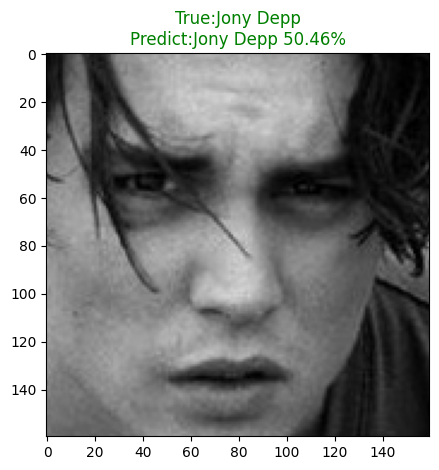

In [19]:
import matplotlib.pyplot as plt

plt.imshow(random_face)
title = f'True:{random_names[0]}\nPredict:{predict_names[0]} {class_prob:.2f}%'
if random_names == predict_names:
    c = 'g'
else:
    c = 'r'
plt.title(title,c=c)
plt.tight_layout()
plt.show()

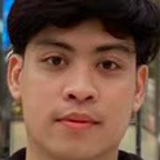

In [21]:
filename  = './Image/10_classes/Alex/alex.jpg'
img = extract_face(filename)
Image.fromarray(img)

In [22]:
embed = get_embedding(facenet_model,img)
embed = np.expand_dims(embed,axis=0)
embed_norm = in_coder.transform(embed)

index = model.predict(embed_norm)
prob = model.predict_proba(embed_norm)

class_index = index[0]
class_prob = prob[0,class_index]*100
predict_names = out_coder.inverse_transform(index)

1/1 [==============================] - 10s 10s/step


In [32]:
def extract_face2(img,re_size=(160,160)):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detectMultiScale(gray_img,1.1,5)
    if len(faces) == 0:
        return None
    x,y,w,h = faces[0]
    face = img[y:y+h,x:x+w]
    img_face = Image.fromarray(cv2.cvtColor(face,cv2.COLOR_BGR2RGB))
    img = img_face.resize(re_size)
    face_arr = np.asarray(img)
    return face_arr

def get_embedding2(facenet_model, face):
    if face is None:
        return None
    
    face_pixel = face.astype('float32')
    samples = np.expand_dims(face_pixel, axis=0)
    embedd = facenet_model.embeddings(samples)
    return embedd[0]

In [34]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if ret == True:
        face = extract_face2(frame)
        face_embed = get_embedding2(facenet_model, face)
        if face_embed is not None:
            samples = np.expand_dims(face_embed,axis=0)
            index = model.predict(samples)
            predict_names = out_coder.inverse_transform(index)
            print(predict_names)
            cv2.imshow('output', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('d'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 224ms/step
['Taylor Swift']
1/1 [==============================] - 0s 339ms/step
['Alex']
1/1 [==============================] - 0s 267ms/step
['Alex']
1/1 [==============================] - 0s 190ms/step
['Taylor Swift']
1/1 [==============================] - 0s 284ms/step
['Alex']
1/1 [==============================] - 0s 301ms/step
['Taylor Swift']
1/1 [==============================] - 0s 360ms/step
['Taylor Swift']
1/1 [==============================] - 0s 161ms/step
['Alex']
1/1 [==============================] - 0s 285ms/step
['Taylor Swift']
1/1 [==============================] - 0s 177ms/step
['Alex']


In [35]:
import pickle 

#pickle.dump(model,open('model.p','wb'))